notebook reimplemented from: https://github.com/nicknochnack/RealTimeObjectDetection

# 0. Setup Paths

In [15]:
WORKSPACE_PATH = 'Tensorflow/workspace'; print("WORKSPACE_PATH       :" + WORKSPACE_PATH)
SCRIPTS_PATH = 'Tensorflow/scripts'; print("SCRIPTS_PATH         :" + SCRIPTS_PATH)
APIMODEL_PATH = 'Tensorflow/models'; print("APIMODEL_PATH        :" + APIMODEL_PATH)
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'; print("ANNOTATION_PATH      :" + ANNOTATION_PATH)
IMAGE_PATH = WORKSPACE_PATH+'/images'; print("IMAGE_PATH           :" + IMAGE_PATH)
MODEL_PATH = WORKSPACE_PATH+'/models'; print("MODEL_PATH           :" + MODEL_PATH)
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'; print("PRETRAINED_MODEL_PATH:" + PRETRAINED_MODEL_PATH)
CONFIG_PATH = MODEL_PATH+'/my_ssd_resnet50/pipeline.config'; print("CONFIG_PATH          :" + CONFIG_PATH)
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_resnet50/'; print("CHECKPOINT_PATH      :" + CHECKPOINT_PATH)

WORKSPACE_PATH       :Tensorflow/workspace
SCRIPTS_PATH         :Tensorflow/scripts
APIMODEL_PATH        :Tensorflow/models
ANNOTATION_PATH      :Tensorflow/workspace/annotations
IMAGE_PATH           :Tensorflow/workspace/images
MODEL_PATH           :Tensorflow/workspace/models
PRETRAINED_MODEL_PATH:Tensorflow/workspace/pre-trained-models
CONFIG_PATH          :Tensorflow/workspace/models/my_ssd_resnet50/pipeline.config
CHECKPOINT_PATH      :Tensorflow/workspace/models/my_ssd_resnet50/


# 1. Create Label Map

In [16]:
# isi dari label map
labels = [{'name':'BlastCell', 'id':1}, {'name':'NonBlastCell', 'id':2}]

# write label_map.pbtxt
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [17]:
#!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
#!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

In [18]:
# manual command
print('-'*127)
print('CMD FOR train.record:')
print(f"python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGE_PATH}/train -l {ANNOTATION_PATH}/label_map.pbtxt -o {ANNOTATION_PATH}/train.record")
print('-'*127)
print('CMD FOR test.record:')
print(f"python {SCRIPTS_PATH}/generate_tfrecord.py -x {IMAGE_PATH}/test -l {ANNOTATION_PATH}/label_map.pbtxt -o {ANNOTATION_PATH}/test.record")

-------------------------------------------------------------------------------------------------------------------------------
CMD FOR train.record:
python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/train -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/train.record
-------------------------------------------------------------------------------------------------------------------------------
CMD FOR test.record:
python Tensorflow/scripts/generate_tfrecord.py -x Tensorflow/workspace/images/test -l Tensorflow/workspace/annotations/label_map.pbtxt -o Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [19]:
#!cd Tensorflow && git clone https://github.com/tensorflow/models

In [20]:
#import wget

In [21]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz')
#!move ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}

In [22]:
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [23]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [24]:
CUSTOM_MODEL_NAME = 'my_ssd_resnet50' 

In [25]:
#!mkdir {'Tensorflow\\workspace\\models\\'+CUSTOM_MODEL_NAME}
#!copy {PRETRAINED_MODEL_PATH+'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

# 5. Update Config For Transfer Learning

In [26]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [27]:
# Checking Available GPU 
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(physical_devices[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [28]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [29]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [30]:
# pipeline check
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.0004
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.03
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatched_threshold: 0.5
       ignore_thresholds: fal

In [31]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [32]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [33]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [34]:
# configured pipeline
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.0004
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.03
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatched_threshold: 0.5
       ignore_thresholds: fal

# 6. Train the model

In [35]:
print("use terminal command for training model:\n")
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

use terminal command for training model:

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50 --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50/pipeline.config --num_train_steps=5000


# 7. Load Train Model From Checkpoint

In [36]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [37]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-59')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect White Blood Cells

In [38]:
import cv2 
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [43]:
# read by path
img = cv2.imread("img_1.jpg") # baca gambar
image_np = np.array(img)        # ubah ke np
#print(img)
#print(image_np)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=20,
            min_score_thresh=.75,
            agnostic_mode=False)

array([[[160, 158, 157],
        [165, 163, 162],
        [167, 168, 164],
        ...,
        [165, 173, 166],
        [155, 168, 160],
        [157, 170, 162]],

       [[159, 157, 156],
        [162, 160, 159],
        [160, 164, 159],
        ...,
        [159, 170, 162],
        [152, 165, 157],
        [154, 167, 159]],

       [[163, 164, 162],
        [164, 165, 163],
        [162, 166, 161],
        ...,
        [157, 167, 161],
        [150, 165, 157],
        [151, 166, 158]],

       ...,

       [[157, 159, 160],
        [157, 159, 160],
        [158, 160, 160],
        ...,
        [134, 130, 141],
        [132, 128, 139],
        [132, 126, 137]],

       [[159, 158, 160],
        [159, 158, 160],
        [158, 158, 158],
        ...,
        [137, 132, 141],
        [135, 129, 140],
        [135, 127, 138]],

       [[162, 159, 161],
        [161, 158, 160],
        [157, 157, 157],
        ...,
        [141, 133, 143],
        [139, 131, 141],
        [139, 130, 140]]

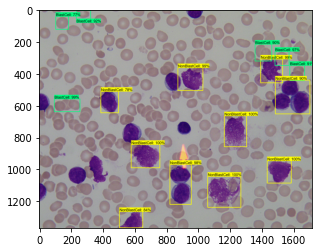

In [44]:
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
# save image in same directory as ipynb
from PIL import Image
im = Image.fromarray(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
im.save("img_1-Detected.jpg")